In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.utils import *
from metrics.query import DataFrameQuery
from common.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from pathlib import Path
from collections import Counter
!export OMP_NUM_THREADS=10

In [3]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
_PATH_RESULT = Path("/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

In [9]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
_PATH_RESULT = Path("/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

class Pipeline():
    def __init__(self):
        self.df = None
    
    def preprocess(self, query):
        hidden_states, logits, hidden_states_stat = self.retrieve(query)
        
        filtered_hidden_states, filtered_logits, filter_hidden_states_stat, repeated_indices = filter_indentical_rows(hidden_states, logits, hidden_states_stat)
        return filtered_hidden_states, \
               filtered_logits, \
               filter_hidden_states_stat, \
               repeated_indices
        

            
    def compute(self):
        z = 1
        models = ["meta-llama/Llama-2-7b-hf",
                  "meta-llama/Llama-2-7b-chat-hf",
                  "meta-llama/Llama-2-13b-chat-hf",
                  "meta-llama/Llama-2-70b-hf",
                  "meta-llama/Llama-2-70b-chat-hf",
                  "meta-llama/Llama-3-8b-hf",
                  "meta-llama/Llama-3-70b-hf",]
        rows = []
        for model in models:
            for shot in [0,5]:
                if "chat" in model and shot == 5:
                    continue
                elif "70" in model and shot == 5:
                    shot = 4
                dict_query = {"method":"last",
                              "model_name": model,
                              "train_instances": shot}
                hidden_states, logits, hidden_states_stat, repeated_indices = self.preprocess(dict_query)
                for layer in [3,7,20,33]:
                    print(f'Iteration with model:{model}, shot:{shot}, layer:{layer}')
                    # compute clustering
                    print(hidden_states.shape)
                    if layer == 33:
                        data = Data(logits)
                    else:
                        data = Data(hidden_states[:,layer,:])
                    data.compute_distances(maxk=1000)
                    clusters_assignement = data.compute_clustering_ADP(Z=z)
                    
                    # filter small cluster
                    cluster_to_remove = np.where(np.bincount(clusters_assignement)<20)
                    bad_indices = np.where(np.isin(clusters_assignement, cluster_to_remove[0]))[0]
                    clusters_assignement = np.delete(clusters_assignement, bad_indices)
                    filtered_hidden_states_stat = hidden_states_stat.drop(bad_indices)
                    
                    
                    # compute centroids
                    distance_matrix = self.compute_centroids(data, cluster_to_remove)
                    
                    # compute attributes
                    cluster_counts, most_represented = self.attributes_df(clusters_assignement, 
                                                                          filtered_hidden_states_stat)
                    
                    row = [model, shot, layer, most_represented, distance_matrix, cluster_counts]
                    rows.append(row)
                checkpoint_path = Path(_PATH_RESULT / f"checkpoint.pkl")
                
                with open(checkpoint_path, "wb") as f:
                    pickle.dump(rows, f)
            
        df = pd.DataFrame(rows, columns = ["model", 
                                           "shot", 
                                           "layer", 
                                           "most_represented", 
                                           "distance_matrix", 
                                           "cluster_counts"])
        self.df = df
                    
    def plot(self):
        for index, row in self.df.iterrows():
            model = row["model"]
            shot = row["shot"]
            layer = row["layer"]
            most_represented = row["most_represented"]
            distance_matrix = row["distance_matrix"]
            cluster_counts = row["cluster_counts"]    
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            ax.set_title('Cluster Visualization')
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
            plt.title(f"Model: {model}, Shot: {shot}, Layer: {layer}") 
            plt.show()
            print(model.split("/")[1])
            plt.savefig(_PATH_RESULT / f"model_{model.split('/')[1]}_shot_{shot}_layer_{layer}.png")
        
    def retrieve(self, query):
        tsm = TensorStorageManager()
        query = DataFrameQuery(query)
        hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")
        return hidden_states,logits, hidden_states_stat
        
    def attributes_df(self,  
                      clusters_assignement, 
                      hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        map_sub_ind = {class_name: n for n,class_name in enumerate(set(subjects))}
        map_ind_sub = {n: class_name for n,class_name in enumerate(set(subjects))}
        
        label_per_row = np.array([map_sub_ind[e] for e in subjects])
        cluster_sub = np.concatenate([np.expand_dims(label_per_row,axis =0),np.expand_dims(clusters_assignement,axis =0)], axis = 0)
        cluster_sub = cluster_sub.T
        
        stem,not_stem = self.stem(hidden_states_stat)
        sub_binary = list(map(lambda r: r in stem,list(map(lambda r: map_ind_sub[r],cluster_sub[:,0]))))
        
        df = pd.DataFrame({"type": sub_binary, "cluster": cluster_sub[:,1]})
        
        df["type"] = df["type"].astype(int)
        most_represented = df.groupby('cluster')['type'].agg(lambda x: x.mean()).reset_index()
        most_represented.rename(columns={"type":"percentage"}, inplace=True)
        
        cluster_counts = Counter(cluster_sub[:, 1])
        
        return cluster_counts, most_represented
    
    def stem(self, 
             hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        subjects_list = np.unique(subjects)
        stem_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'college_biology', 'college_chemistry',
                 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics',
                 'computer_security', 'conceptual_physics', 'electrical_engineering', 'high_school_biology',
                 'high_school_chemistry', 'high_school_computer_science', 'high_school_mathematics',
                 'high_school_physics', 'high_school_statistics', 'machine_learning', 'medical_genetics',
                 'professional_medicine', 'virology', 'elementary_mathematics']

        # Determine STEM and non-STEM
        is_stem = np.isin(subjects_list, stem_subjects)
        stem = subjects_list[is_stem]
        not_stem = subjects_list[~is_stem]
        
        return stem, not_stem
    
    def compute_centroids(self, data, cluster_to_remove):
        # compute centroids
        indices_per_cluster = data.cluster_indices
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = np.stack(centroids)
        centroids = np.delete(centroids,cluster_to_remove, axis=0)

        distance_matrix = pairwise_distances(centroids, metric='l2')
        
        return distance_matrix
            
    def run(self):
        self.compute()
        self.plot()
        
    
def find_identical_rows(matrix):
    
    # View the rows as a structured array to handle them as tuples
    dtype = [('row', matrix.dtype, matrix.shape[1])]
    structured_array = matrix.view(dtype)
    
    # Find unique rows and their indices
    _, inverse_indices = np.unique(structured_array, return_inverse=True)
    
    # Find where each row appears for the first time and their counts
    unique_rows, counts = np.unique(inverse_indices, return_counts=True)
    
    # Filter out unique rows, keeping only duplicates
    repeated_indices = [np.where(inverse_indices == i)[0] for i in unique_rows[counts > 1]]
    return repeated_indices

def filter_indentical_rows(hidden_states,logits, hidden_states_stat):
    # we pick only 7 because the repeated indices are supposed to be equal at each layer
    repeated_indices = find_identical_rows(hidden_states[:,7,:])
    indices_to_exclude = [index[0] for index in repeated_indices]
    filtered_hidden_states = np.delete(hidden_states, indices_to_exclude, axis=0)
    filtered_logits = np.delete(logits, indices_to_exclude, axis=0)
    filtered_hidden_states_stat = hidden_states_stat.drop(indices_to_exclude)
    filtered_hidden_states_stat.reset_index(inplace=True)
    print(filtered_hidden_states.shape)
    return filtered_hidden_states, filtered_logits, filtered_hidden_states_stat, repeated_indices

In [ ]:
pipeline = Pipeline()
pipeline.run()

(14012, 33, 4096)
Iteration with model:meta-llama/Llama-2-7b-hf, shot:0, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:0, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:0, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:0, layer:33
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-2-7b-hf, shot:5, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:5, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:5, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-hf, shot:5, layer:33
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-2-7b-chat-hf, shot:0, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-chat-hf, shot:0, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-chat-hf, shot:0, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-7b-chat-hf, shot:0, layer:33
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 41, 5120)
Iteration with model:meta-llama/Llama-2-13b-chat-hf, shot:0, layer:3
(14012, 41, 5120)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-13b-chat-hf, shot:0, layer:7
(14012, 41, 5120)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-13b-chat-hf, shot:0, layer:20
(14012, 41, 5120)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-13b-chat-hf, shot:0, layer:33
(14012, 41, 5120)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-2-70b-hf, shot:0, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:0, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:0, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:0, layer:33
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-2-70b-hf, shot:4, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:4, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:4, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-hf, shot:4, layer:33
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-2-70b-chat-hf, shot:0, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-chat-hf, shot:0, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-chat-hf, shot:0, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-2-70b-chat-hf, shot:0, layer:33
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:0, layer:33
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-hf, shot:5, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:5, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:5, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-hf, shot:5, layer:33
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-3-70b-hf, shot:0, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-hf, shot:0, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-hf, shot:0, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-hf, shot:0, layer:33
(14012, 81, 8192)


In [4]:
with open(Path(_PATH_RESULT,"checkpoint.pkl"), "rb") as f:
    df = pickle.load(f)
# with open(Path(_PATH_RESULT,"checkpoint_0.pkl"), "rb") as f:
#     df_0 = pickle.load(f)

In [5]:
# df_0 = pd.DataFrame(df_0, columns = ["model", 
#                                    "shot", 
#                                    "layer", 
#                                    "most_represented", 
#                                    "distance_matrix", 
#                                    "cluster_counts"])
df = pd.DataFrame(df, columns = ["model", 
                                   "shot", 
                                   "layer", 
                                   "most_represented", 
                                   "distance_matrix", 
                                   "cluster_counts"])

In [7]:
df["model"].unique()

array(['meta-llama/Llama-2-7b-hf', 'meta-llama/Llama-2-7b-chat-hf',
       'meta-llama/Llama-2-13b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-3-8b-hf',
       'meta-llama/Llama-3-70b-hf'], dtype=object)

In [9]:
df.to_pickle("df_002.pkl")

In [8]:
pipeline.df = df_all

In [ ]:
pipeline.plot()

In [48]:
!export OMP_NUM_THREADS=30

In [10]:
def retrieve_from_storage_npy(query):
    query_dict = query.query
    #TODO - Adapt path to query
    #import pdb; pdb.set_trace()
    adapted_name = query_dict["model_name"][11:].lower()
    adapted_name = adapted_name[:-3]
    storage_path = Path(f"/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/results/mmlu/{adapted_name}/{query_dict['train_instances']}shot")
    files = os.listdir(storage_path)

    # Filter files with the specific pattern and range check
    pattern = re.compile(r'l(\d+)_target\.pt')
    filtered_files = [file for file in files if pattern.match(file)]

    # Sort files based on the number in the filename
    filtered_files.sort(key=lambda x: int(pattern.match(x).group(1)))

    # Load tensors and add them to a list
    tensors = [torch.load(os.path.join(storage_path, file)) for file in filtered_files]

    # Stack all tensors along a new dimension
    stacked_tensor = torch.stack(tensors[:-1])
    stacked_tensor = rearrange(stacked_tensor, 'l n d -> n l d')
    logits = tensors[-1]

    #retrieve statistics
    with open(Path(storage_path,"statistics_target.pkl"), "rb") as f:
        stat_target = pickle.load(f)
    for key in stat_target.keys():
        if isinstance(stat_target[key],float):
            continue
        stat_target[key] = stat_target[key][:14040] 
    
    df = pd.DataFrame(stat_target)
    df = df.rename(columns={"subjects":"dataset", "predictions":"std_pred","answers":"letter_gold", "contrained_predictions":"only_ref_pred",})
    df["train_instances"] = query_dict["train_instances"]
    df["model_name"] = query_dict["model_name"] #"meta-llama-Llama-2-7b-hf"
    df["method"] = "last"
    
    #df = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/df.pkl")

    return stacked_tensor.float().numpy(), logits.float().numpy(), df

In [28]:
dict_query = {"method":"last",
              "model_name":  "meta-llama/Llama-3-70b-hf",
              "train_instances": 0}
query = DataFrameQuery(dict_query)                                     
stat_target = retrieve_from_storage_npy(query)

In [18]:
for key in stat_target.keys():
    if isinstance(stat_target[key],list):
        print(f'{key}:{len(stat_target[key])}')

subjects:14040


In [26]:
stat_target["accuracy"][:14040]

TypeError: 'float' object is not subscriptable

In [ ]:
["model", 
                                   "shot", 
                                   "layer", 
                                   "most_represented", 
                                   "distance_matrix", 
                                   "cluster_counts"])

In [66]:
df_all["model"] = df_all["model"].apply(lambda r: r[:-3])

In [ ]:
for model in df["model"].unique():
    for shot in df["shot"].unique():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
        for n,layer in enumerate(df["layer"].unique()):
            n=n-1
            df_iter = df.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            row = df_iter.to_dict()
            model = list(row["model"].items())[0][1]
            shot = list(row["shot"].items())[0][1]
            layer = list(row["layer"].items())[0][1]
            most_represented = list(row["most_represented"].items())[0][1]
            distance_matrix = list(row["distance_matrix"].items())[0][1]
            cluster_counts = list(row["cluster_counts"].items())[0][1]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                print(pos)
                axs[n].scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            axs[n].set_title(f"{model.split('/')[1]},shot:{shot},layer:{layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')
            plt.tight_layout()
        plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
        plt.show()
        plt.savefig(_PATH_RESULT / f"{model.split('/')[1]}_shot_{shot}.png")

array([ 3,  7, 20, 33])

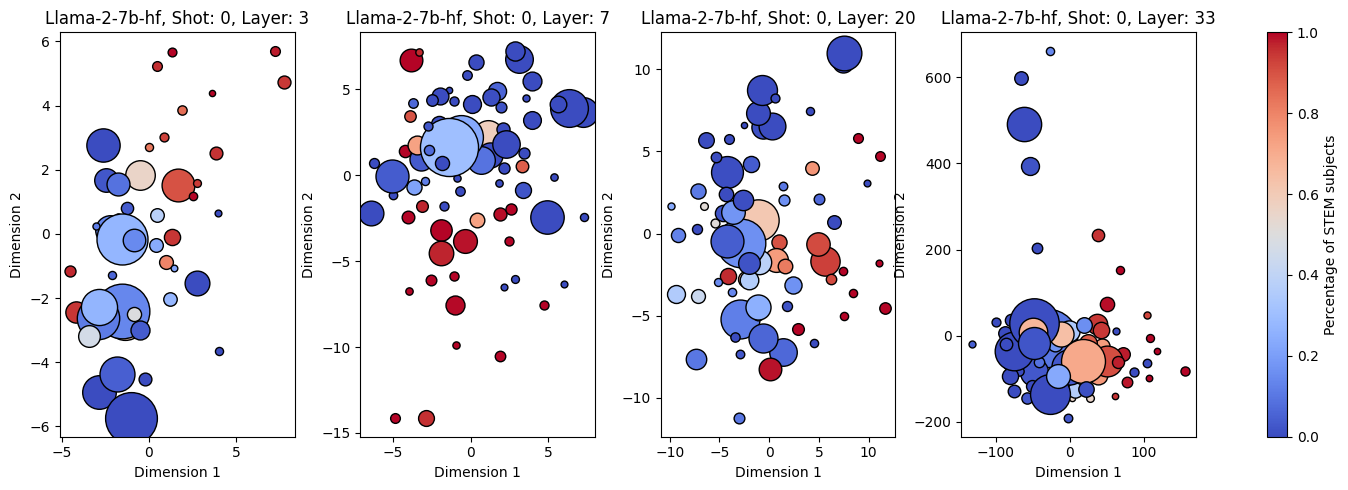

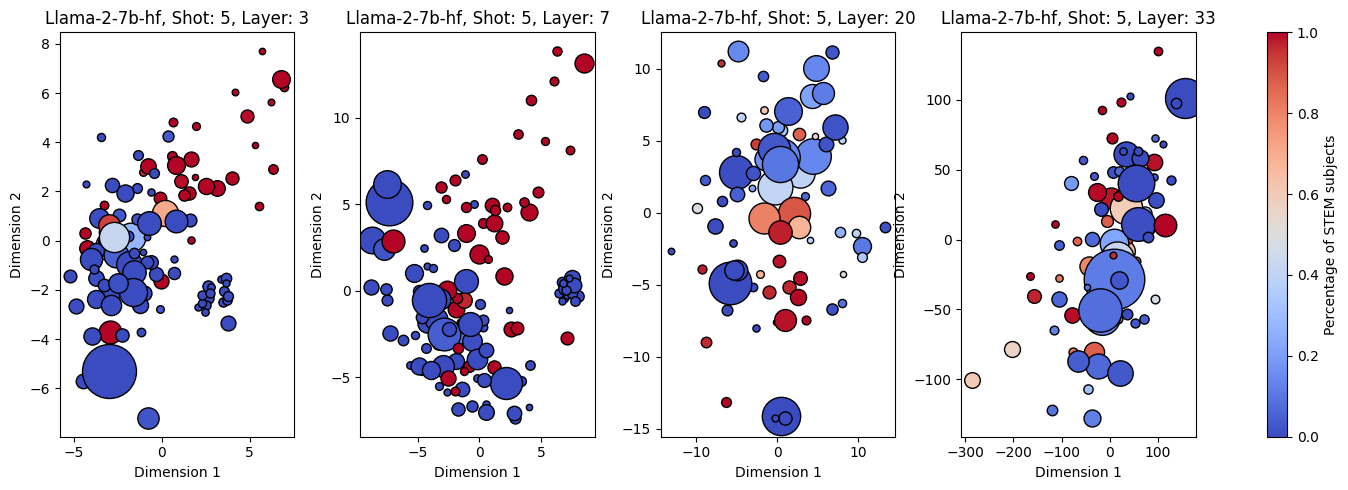

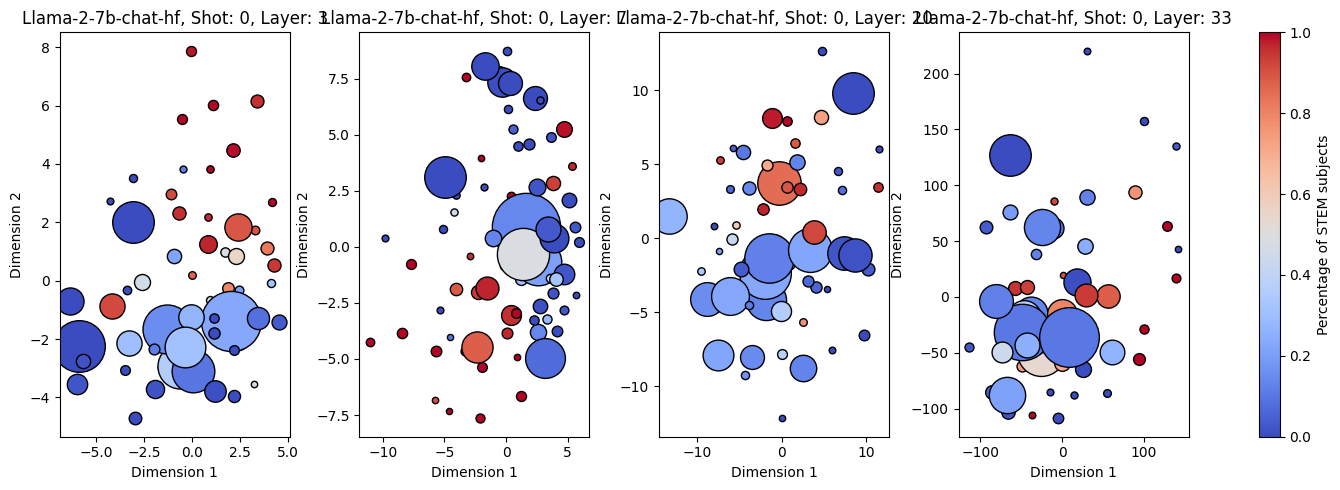

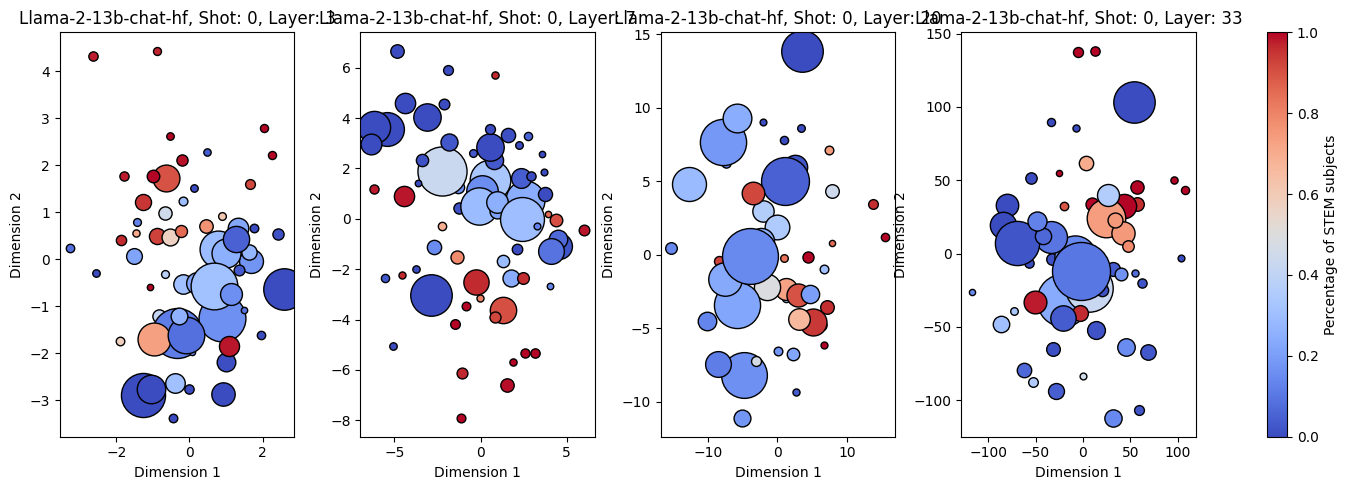

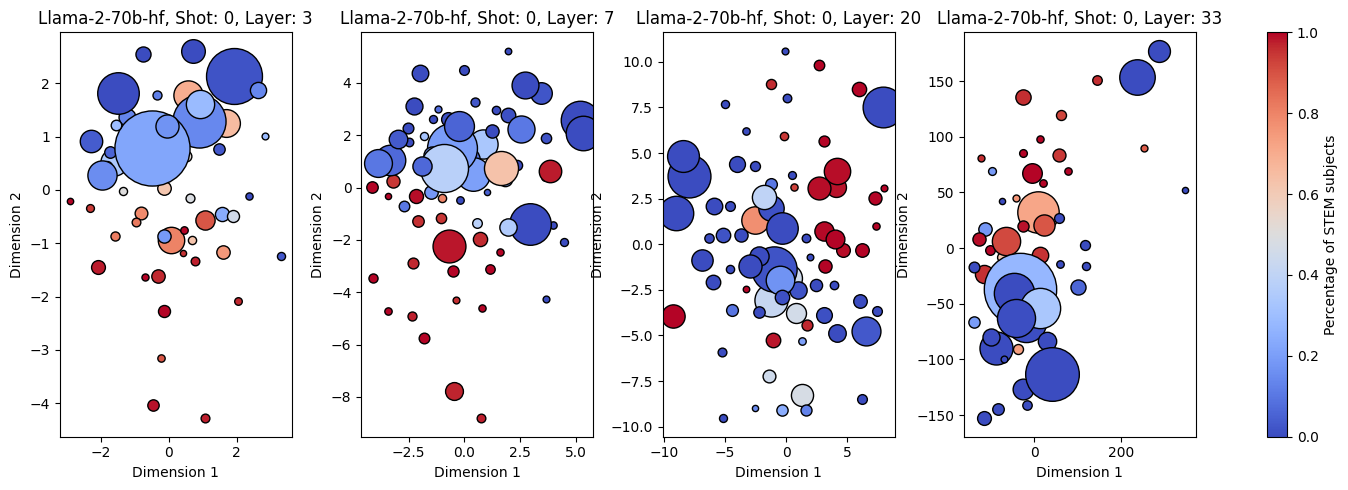

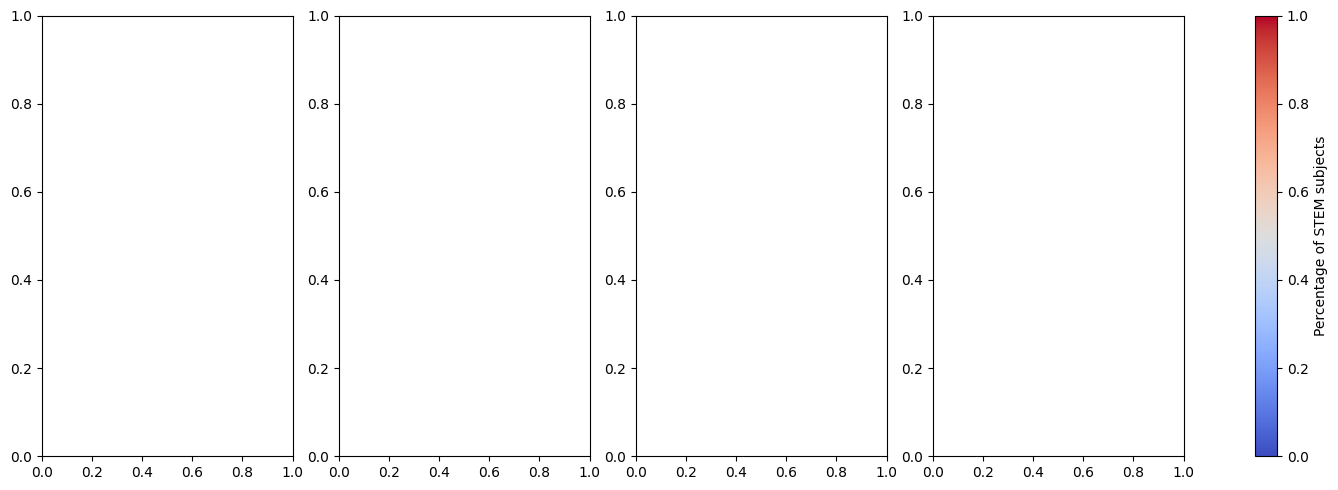

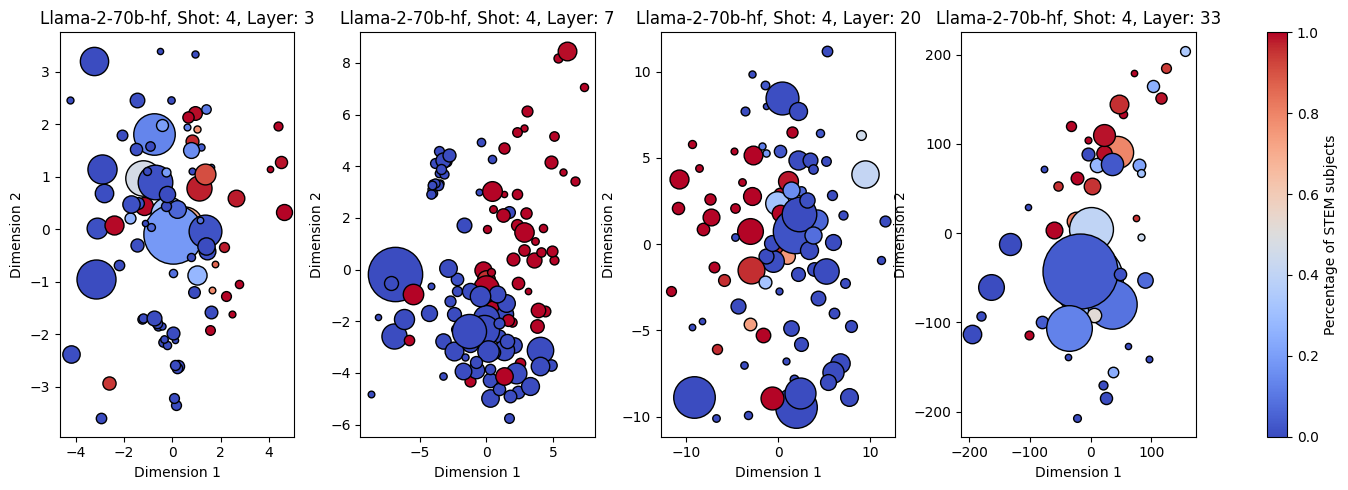

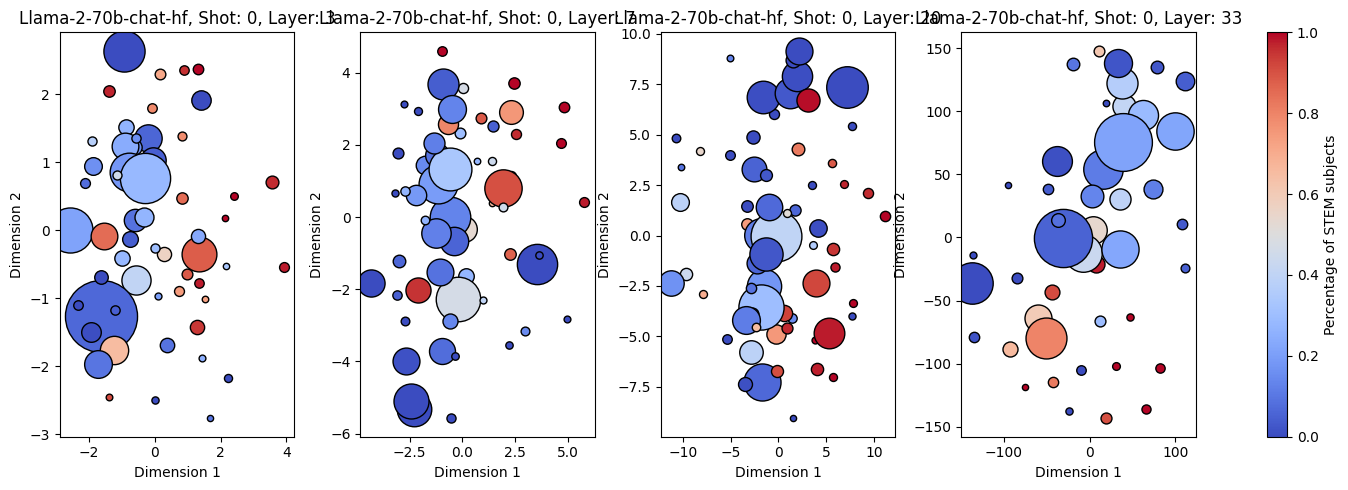

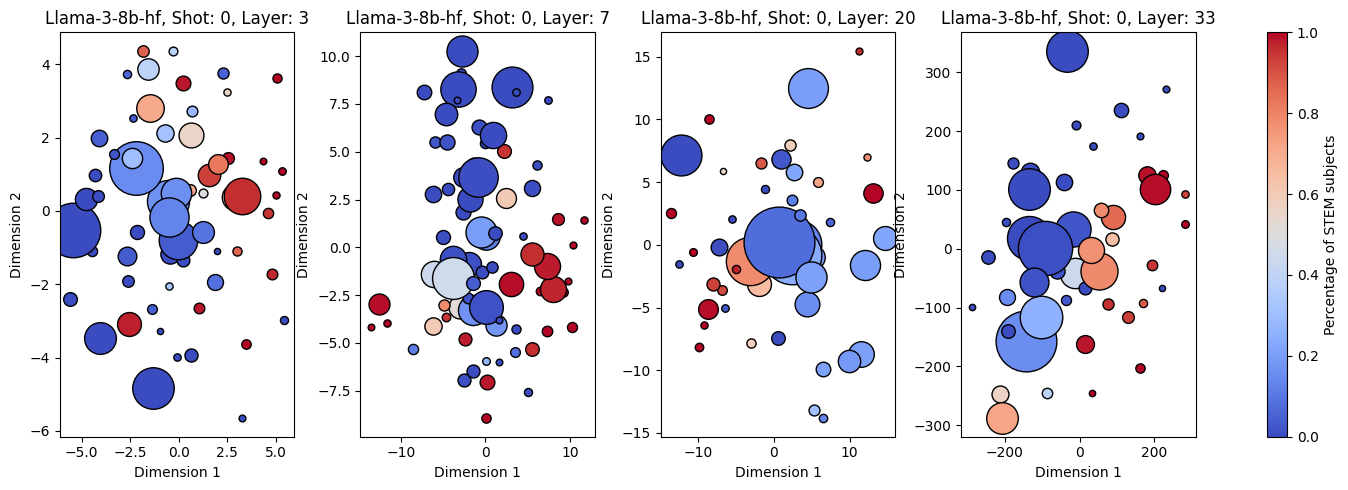

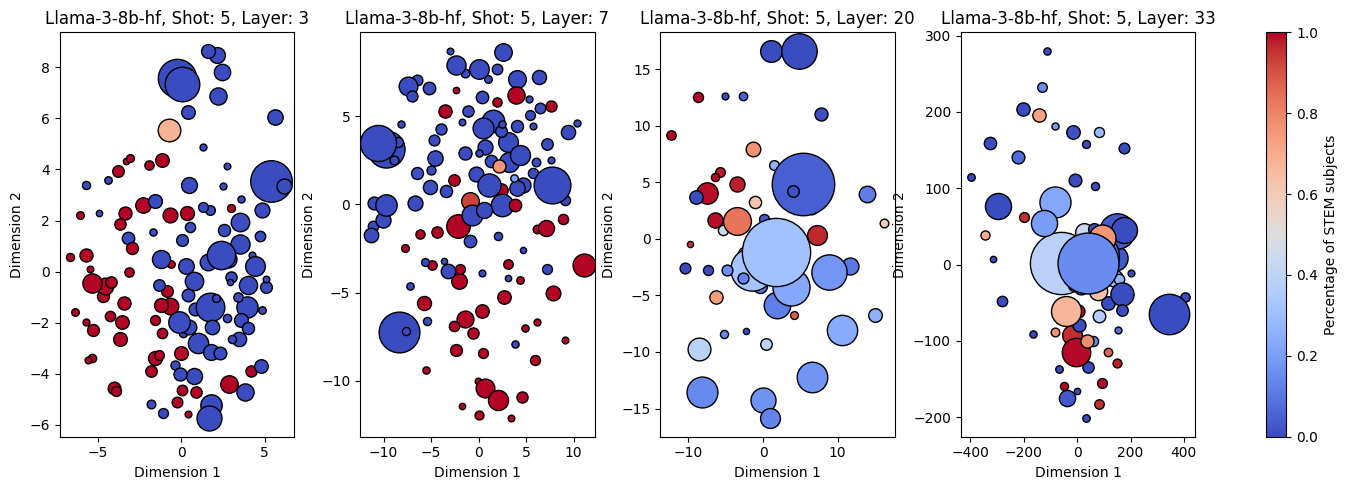

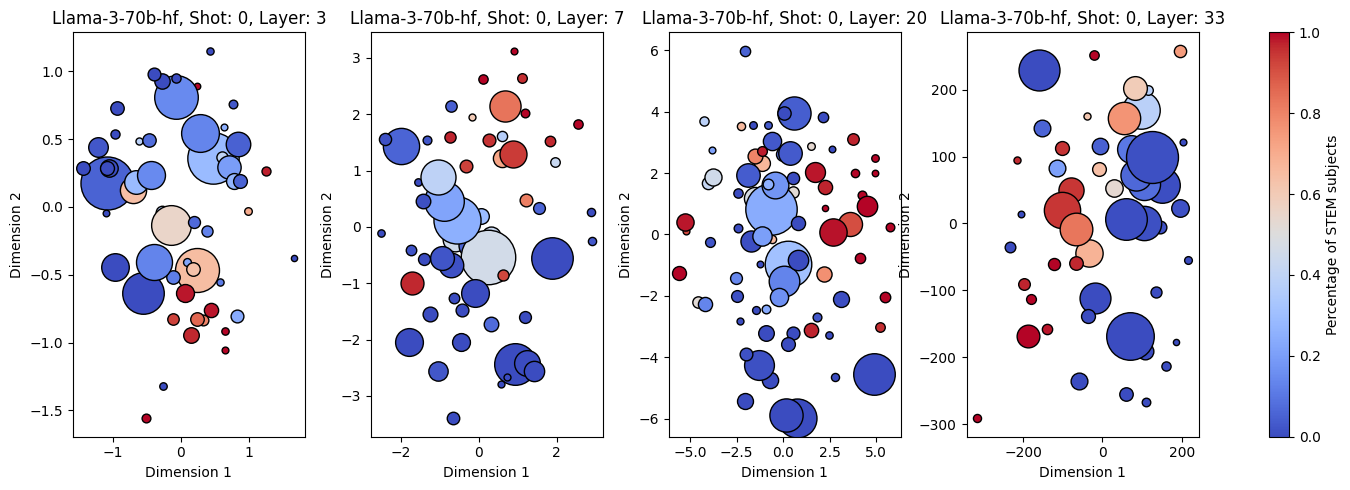

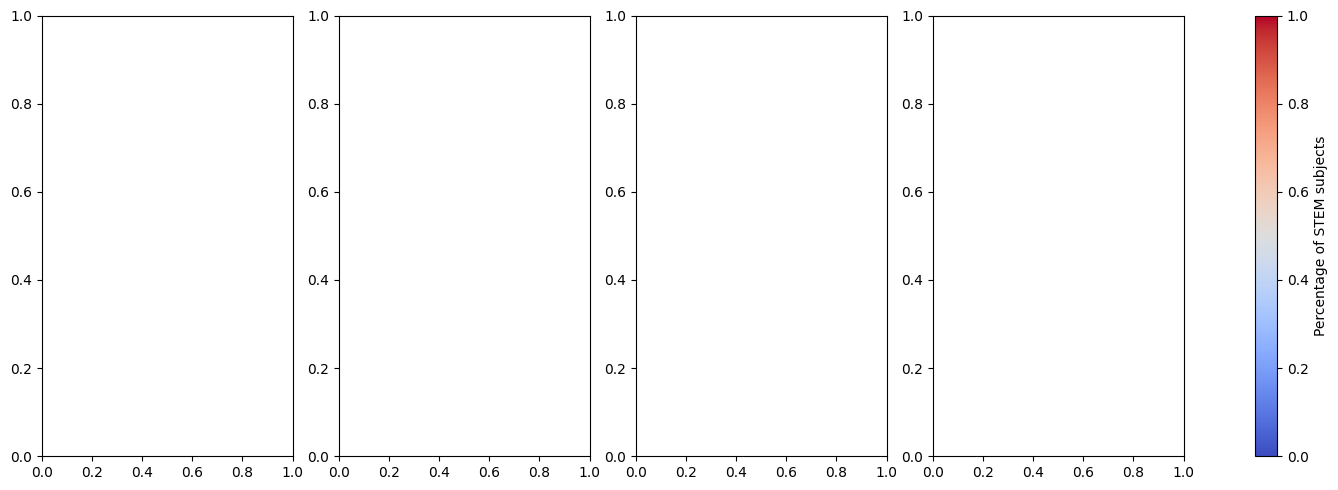

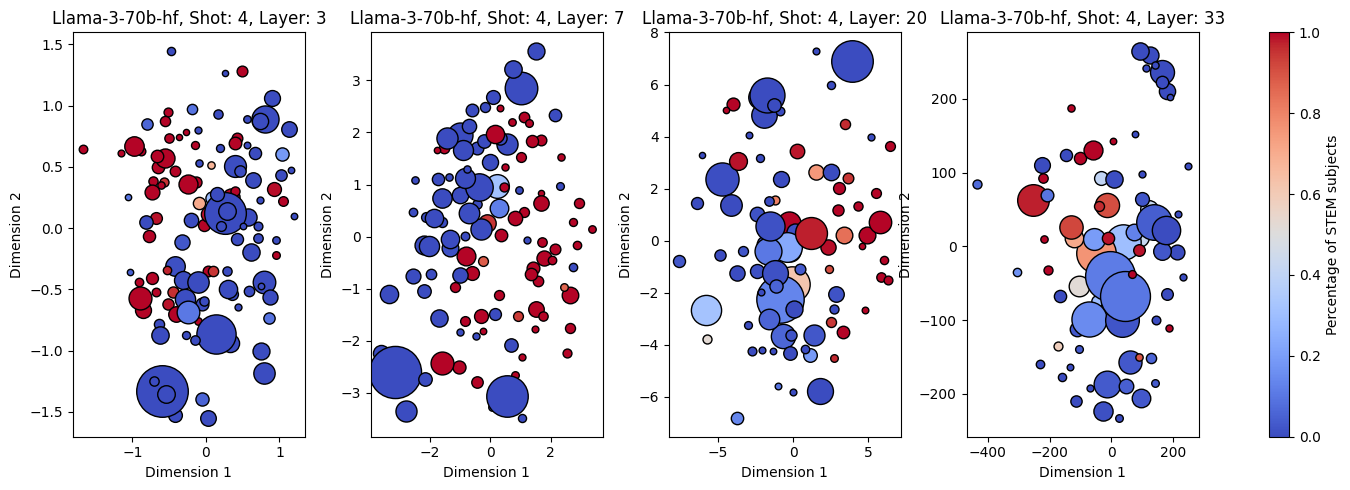

In [15]:
for model in df["model"].unique():
    for shot in df["shot"].unique():
        if '70' not in model and shot == 4:
            continue
        elif 'chat' in model and shot != 0:
            continue
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns
        
        for n, layer in enumerate(df["layer"].unique()):
            df_iter = df.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            
            if df_iter.empty:
                continue  # Skip if no data is returned for this query
            
            row = df_iter.to_dict('list')
            most_represented = row["most_represented"][0]
            distance_matrix = row["distance_matrix"][0]
            cluster_counts = row["cluster_counts"][0]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            
            for pos, count, cluster, color in zip(positions, counts, clusters, cluster_colors):
                
                axs[n].scatter(pos[0], pos[1], s=count, color=color, label=cluster, edgecolors='black', linewidth=1)
            
            axs[n].set_title(f"{model.split('/')[-1]}, Shot: {shot}, Layer: {layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')

        plt.tight_layout()
        plt.colorbar(scalar_map, ax=axs, label='Percentage of STEM subjects')  # Attaching colorbar to all subplots
        plt.show()
        fig.savefig(_PATH_RESULT / f"{model.split('/')[-1]}_shot_{shot}.png")  # Save the figure after plotting


In [16]:
!pwd

/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon


[ 6.06 -2.51]
[ 4.67 -4.81]
[-1.48  2.27]
[-0.34  2.15]
[-1.39  4.61]
[-1.02  3.56]
[-1.    0.64]
[2.37 1.41]
[1.49 0.66]
[4.91 1.62]
[ 4.55 -2.81]
[ 2.42 -2.3 ]
[-2.82  3.67]
[-1.74  1.86]
[ 3.69 -4.65]
[ 2.46 -3.72]
[ 1.68 -1.84]
[3.15 4.53]
[0.5  2.38]
[ 0.79 -0.33]
[ 3.33 -1.91]
[ 3.79 -1.46]
[ 3.85 -0.33]
[2.81 0.19]
[ 5.7  -2.23]
[ 2.33 -0.28]
[1.38 0.06]
[ 1.64 -0.8 ]
[-1.15 -2.84]
[-0.73 -1.25]
[-1.83  2.16]
[0.94 1.21]
[3.44 1.26]
[-1.11 -2.06]
[-1.98 -1.58]
[-2.11  1.1 ]
[-1.42  1.  ]
[-0.72  1.86]
[ 9.11 -3.57]
[ 5.72 -0.74]
[ 9.89 -0.7 ]
[ 2.95 -0.12]
[2.1  2.15]
[-5.45  1.3 ]
[-4.39 -1.58]
[-5.06  0.78]
[-2.82  4.69]
[-2.34  0.31]
[-0.5 -1.5]
[ 0.11 -1.53]
[-0.05  3.74]
[-2.46 -0.6 ]
[-2.59 -1.1 ]
[-1.06  2.12]
[ 0.65 -2.53]
[ 0.8  -1.74]
[-2.24e-03 -3.32e+00]
[-0.56 -2.86]
[-2.98  0.82]
[ 0.08 -0.88]
[-0.81 -4.02]
[-0.54 -4.25]
[ 0.04 -4.56]
[-0.39 -0.66]
[ 0.5  -0.79]
[-1.9   4.75]
[-0.27  1.23]
[-2.2 -1.2]
[-0.67 -2.08]
[-2.47  1.27]
[-3.33  2.92]
[1.58 1.78]
[-4.57  2.

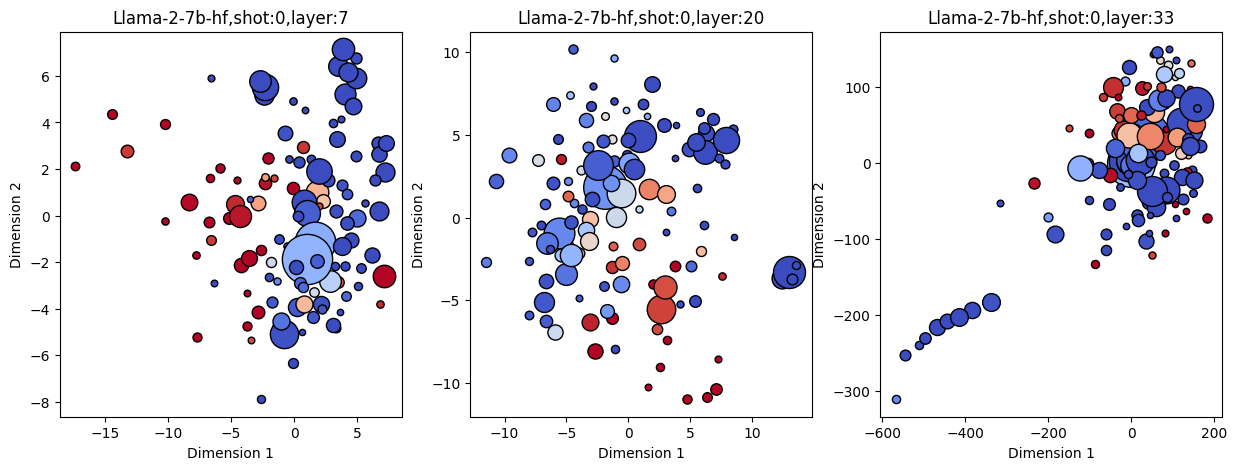

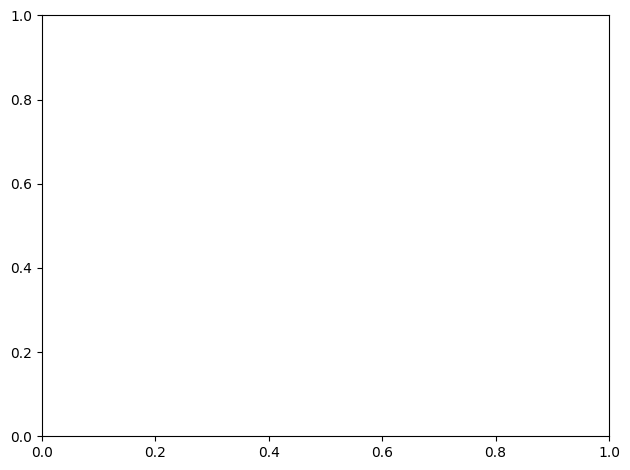

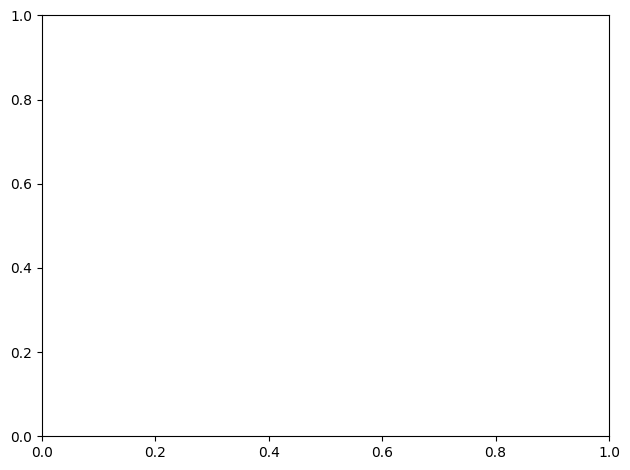

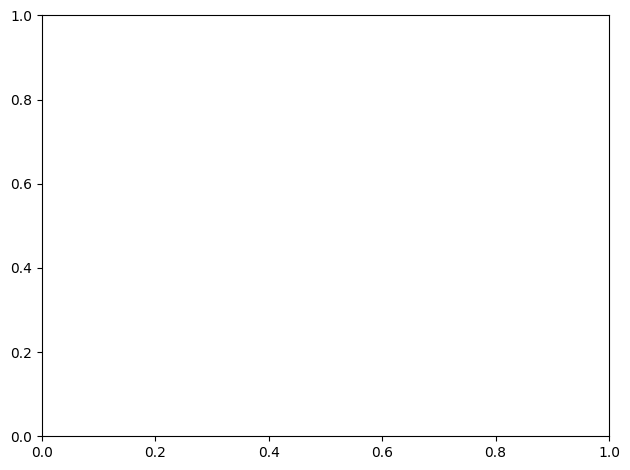

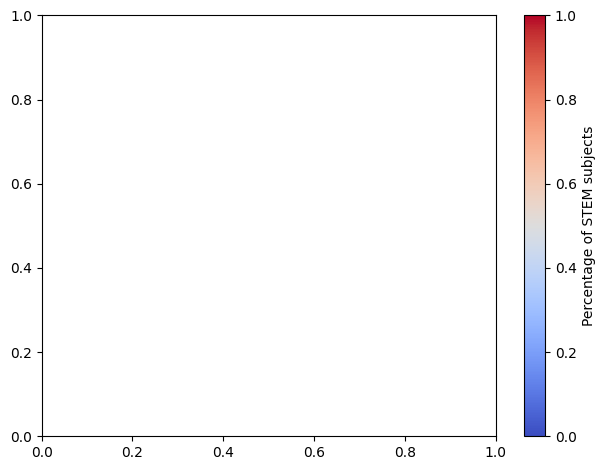

[7.23 2.71]
[5.92 5.33]
[-0.37  1.08]
[-2.1   0.77]
[-3.46  1.42]
[-0.39  1.57]
[ 2.53 -0.12]
[0.39 0.53]
[-3.16 -2.96]
[-0.96  0.69]
[-3.42  0.87]
[-2.61  0.35]
[0.09 0.93]
[-2.19  0.96]
[1.23 3.81]
[0.01 4.2 ]
[5.1  2.19]
[5.7  5.07]
[-1.09  1.34]
[0.06 1.61]
[-1.59 -5.36]
[2.09 3.28]
[0.38 3.66]
[2.87 1.21]
[1.77 2.43]
[2.6  1.87]
[3.03 4.18]
[3.5  1.76]
[-2.18  4.81]
[1.66 2.73]
[2.85 2.58]
[2.52 2.18]
[1.57 3.6 ]
[3.49 2.95]
[3.44 2.22]
[3.79 3.7 ]
[1.05 3.89]
[2.31 5.13]
[1.22 4.55]
[0.18 2.29]
[1.73 1.06]
[-0.37 -0.23]
[-0.87  0.94]
[-3.36  0.38]
[-3.62  1.17]
[-2.95  0.66]
[ 0.27 -2.81]
[1.4  1.94]
[-0.43  2.82]
[4.77 2.35]
[-1.24 -0.21]
[ 0.82 -0.18]
[-3.46 -1.07]
[-3.39 -0.57]
[-1.48 -1.74]
[-2.76  0.01]
[-1.58 -1.95]
[-3.25 -0.08]
[-2.27 -0.02]
[-3.01  3.27]
[6.74 7.7 ]
[8.84 5.68]
[7.36 7.37]
[5.66 7.02]
[7.25 5.59]
[5.14 8.68]
[-1.56  0.33]
[-2.58  0.13]
[0.09 2.61]
[1.86 3.52]
[ 0.08 -1.7 ]
[-3.12 -0.41]
[-1.31 -0.93]
[ 1.51 -3.01]
[-2.37 -2.24]
[0.62 1.82]
[-4.71 -3.77]


<Figure size 640x480 with 0 Axes>

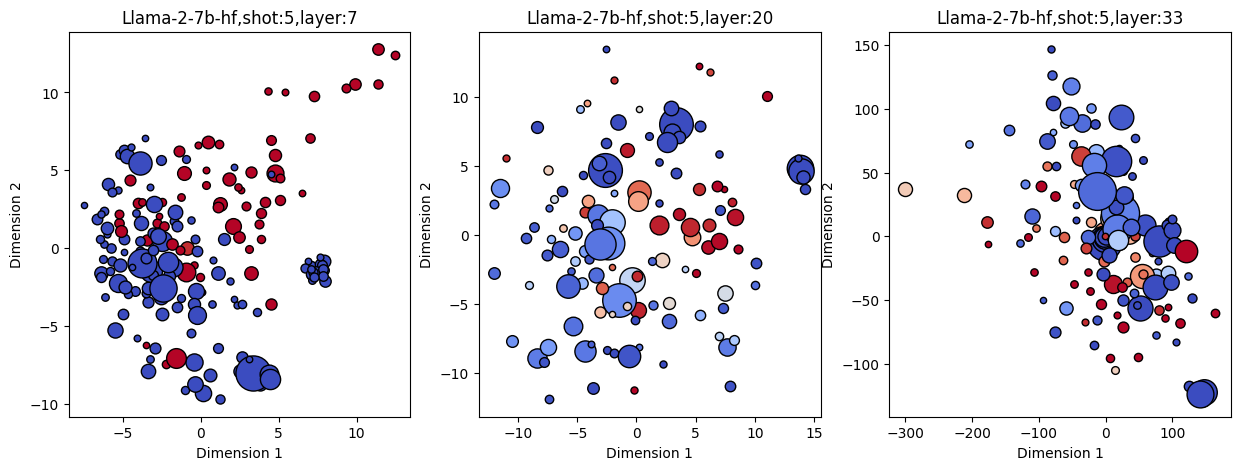

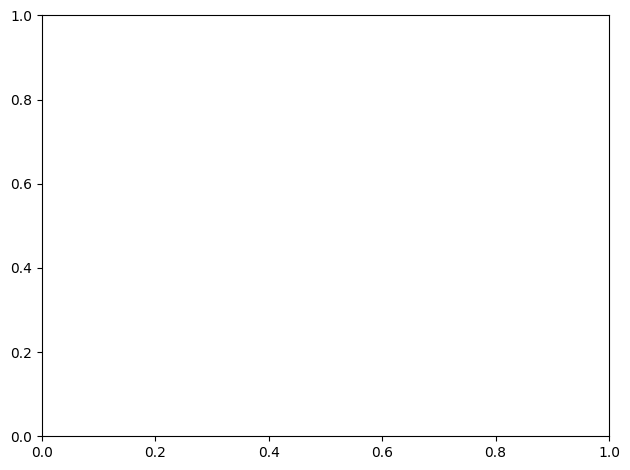

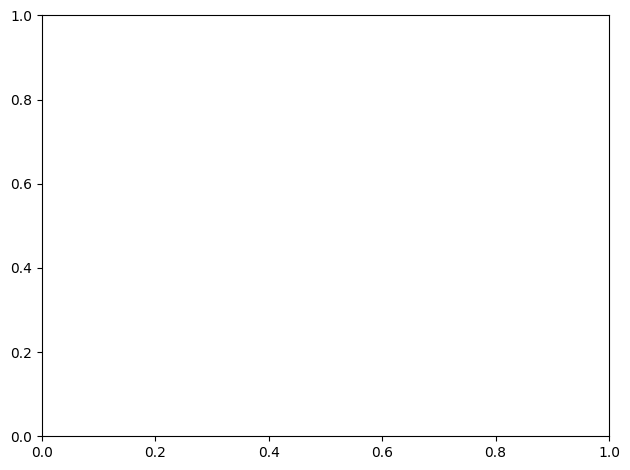

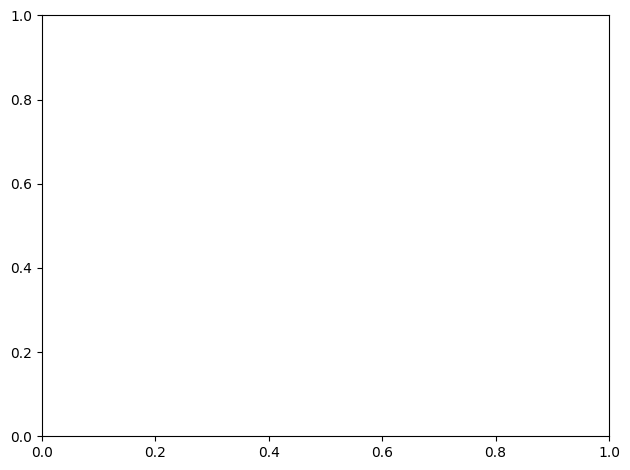

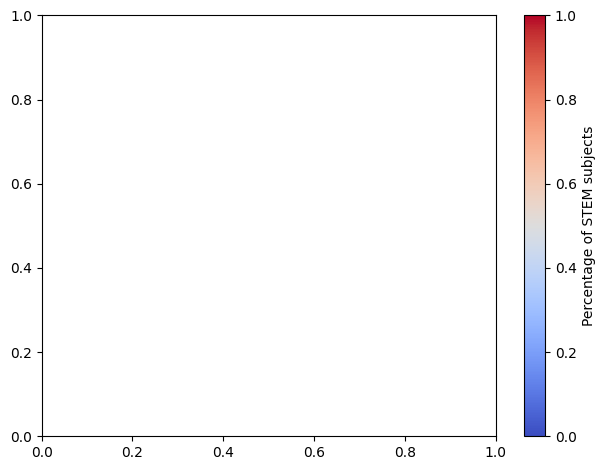

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

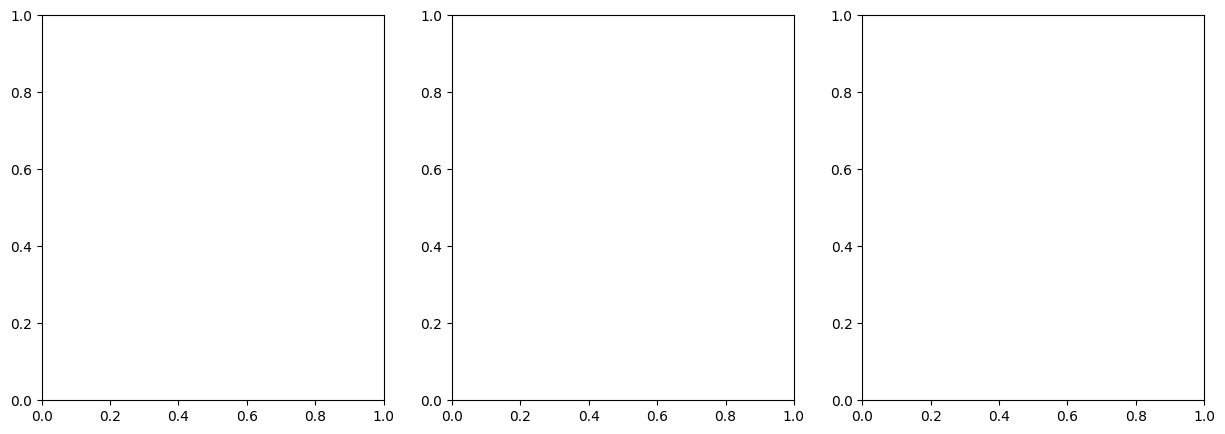

In [14]:
for model in df_all["model"].unique():
    for shot in df_all["shot"].unique():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
        for n,layer in enumerate(df_all["layer"].unique()):
            n=n-1
            df_iter = df_all.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            row = df_iter.to_dict()
            model = list(row["model"].items())[0][1]
            shot = list(row["shot"].items())[0][1]
            layer = list(row["layer"].items())[0][1]
            most_represented = list(row["most_represented"].items())[0][1]
            distance_matrix = list(row["distance_matrix"].items())[0][1]
            cluster_counts = list(row["cluster_counts"].items())[0][1]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                
                axs[n].scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            axs[n].set_title(f"{model.split('/')[1]},shot:{shot},layer:{layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')
            plt.tight_layout()
        plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
        plt.show()
        plt.savefig(_PATH_RESULT / f"{model.split('/')[1]}_shot_{shot}.png")

In [100]:
list(row["model"].items())[0][1]

'meta-llama-Llama-2-7b'

In [85]:
df_iter.to_dict()["distance_matrix"][0]

array([[0.  , 3.81, 8.77, ..., 9.87, 7.57, 6.21],
       [3.81, 0.  , 8.99, ..., 9.8 , 7.53, 6.27],
       [8.77, 8.99, 0.  , ..., 3.67, 4.19, 4.71],
       ...,
       [9.87, 9.8 , 3.67, ..., 0.  , 3.89, 5.67],
       [7.57, 7.53, 4.19, ..., 3.89, 0.  , 3.69],
       [6.21, 6.27, 4.71, ..., 5.67, 3.69, 0.  ]])